In [ ]:
# All library used in the notebook

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import QuantLib as ql

from typing import Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

from urllib.error import URLError
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Iterable, Tuple

import sys
print(sys.executable)

c:\Users\moshi\Downloads\College\ml_club\Binomial_Deamericanization\.venv\Scripts\python.exe


In [48]:
def get_option_chains_all(ticker: str,
                                  max_workers: int = 8) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetches option chains (calls and puts) for every available expiry of a given ticker,
    performing API requests in parallel to reduce total fetch time.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., 'AAPL').
    max_workers : int, optional
        Maximum number of threads to use for concurrent fetching (default is 8).

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        - calls_df: DataFrame containing all calls across expiries, with added columns:
            * 'option_type' = 'call'
            * 'expiration'  = expiry date string 'YYYY-MM-DD'
            * 'TTM'         = time to maturity in years
        - puts_df: DataFrame containing all puts with the same added columns.
    """
    stock = yf.Ticker(ticker)
    expiries = stock.options  # list of expiry date strings
    today = datetime.now().date()

    calls_accum = []
    puts_accum  = []

    def fetch_chain(expiry: str):
        """Fetch calls/puts for a single expiry and return (expiry, calls_df, puts_df)."""
        try:
            chain = stock.option_chain(expiry)
            calls = chain.calls.copy()
            puts  = chain.puts.copy()
        except Exception as e:
            # Return None on error so we can skip later
            return expiry, None, None

        # Tag each row with type and expiration
        calls['option_type']  = 'call'
        puts ['option_type']  = 'put'
        calls['expiration']   = expiry
        puts ['expiration']   = expiry

        # Compute time-to-maturity once
        exp_date = datetime.strptime(expiry, "%Y-%m-%d").date()
        ttm = max((exp_date - today).days / 365.0, 0.0)
        calls['TTM'] = ttm
        puts ['TTM'] = ttm

        return expiry, calls, puts

    # Fetch in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(fetch_chain, exp) for exp in expiries]
        for future in as_completed(futures):
            expiry, calls_df, puts_df = future.result()
            if calls_df is not None and not calls_df.empty:
                calls_accum.append(calls_df)
            if puts_df  is not None and not puts_df.empty:
                puts_accum.append(puts_df)

    # Concatenate results
    all_calls = pd.concat(calls_accum, ignore_index=True) if calls_accum else pd.DataFrame()
    all_puts  = pd.concat(puts_accum,  ignore_index=True) if puts_accum  else pd.DataFrame()

    return all_calls, all_puts


In [49]:
calls, puts = get_option_chains_all("AAPL")

In [ ]:
calls.describe()

In [29]:
def initial_dataset_clean(dataset : pd.DataFrame):
    # Removing columns that will not be used for training or filtering
    cols_to_drop = ["contractSymbol", "lastTradeDate", "change", "percentChange", "expiration", "inTheMoney"]
    dataset.drop(columns=[c for c in cols_to_drop if c in dataset.columns], inplace=True)

    # Removing NA values for stale options
    dataset.dropna(axis=0,subset=["volume"], inplace=True)

    
    return dataset

In [ ]:
calls_clean = initial_dataset_clean(calls)
calls_clean.describe()

In [ ]:
puts_clean = initial_dataset_clean(puts)
puts_clean.describe()

In [32]:
def assign_interest_rates(options_df, curve_series, ttm_col="TTM", out_col="r"):
    """
    Given an options DataFrame with a TTM column (years), append a column `out_col`
    containing the interpolated risk-free rate (decimal) from the Treasury curve.
    Returns a COPY of the DataFrame (does not modify in place).
    """
    if ttm_col not in options_df.columns:
        raise KeyError(f"Column '{ttm_col}' not found in DataFrame.")

    df = options_df.copy()
    df[out_col] = df[ttm_col].astype(float).apply(lambda t: interpolate_rate(t, curve_series))
    return df

In [50]:
def fetch_treasury_yield_curve_latest():
    """
    Returns (as_of_date_iso, curve_series), where curve_series maps:
    maturity in YEARS (float) -> decimal yield (e.g., 0.045 = 4.5%)

    Pulls the official 'Daily Treasury Par Yield Curve Rates' CSV for the
    current year, falling back to the previous year if needed.
    """
    def _read_year(y):
        url = (
            "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/"
            f"daily-treasury-rates.csv/{y}/all?_format=csv&field_tdr_date_value={y}"
            "&type=daily_treasury_yield_curve"
        )
        try:
            df = pd.read_csv(url)
            # Normalize
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df = df.dropna(subset=["Date"]).sort_values("Date")
            # force numeric for all yield columns (coerce N/A)
            for c in df.columns:
                if c != "Date":
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df
        except (URLError, OSError, pd.errors.ParserError):
            return None

    year_now = date.today().year
    df = _read_year(year_now)
    if df is None or df.empty:
        df = _read_year(year_now - 1)
    if df is None or df.empty:
        raise RuntimeError("Could not download Treasury par yield CSV.")

    # Pick the most recent row with at least one yield present
    last = df.dropna(how="all", axis=1).iloc[-1]

    # Map ALL known tenors that might appear. Some years include "1.5 Mo" (≈6 weeks).
    col_to_years = {
        "1 Mo": 1/12,  "1.5 Mo": 1.5/12, "2 Mo": 2/12,  "3 Mo": 3/12,  "4 Mo": 4/12,  "6 Mo": 6/12,
        "1 Yr": 1.0,   "2 Yr": 2.0,      "3 Yr": 3.0,   "5 Yr": 5.0,   "7 Yr": 7.0,
        "10 Yr": 10.0, "20 Yr": 20.0,    "30 Yr": 30.0,
    }

    data = {}
    for col, yrs in col_to_years.items():
        if col in last and pd.notna(last[col]):
            data[yrs] = float(last[col]) / 100.0

    curve_series = pd.Series(data, dtype=float).sort_index()
    if curve_series.empty:
        raise RuntimeError("No yields found in the most recent Treasury row.")
    return last["Date"].date().isoformat(), curve_series

In [ ]:
def interest_rate_interpolation(curve_series, x_eval):
    """
    Build a QuantLib monotone cubic natural spline from curve_series
    and return interpolated/extrapolated values at x_eval.
    """
    xs = [float(x) for x in curve_series.index]
    ys = [float(y) for y in curve_series.values]

    if len(xs) == 0:
        raise ValueError("Empty curve")

    xs, ys = zip(*sorted(zip(xs, ys)))
    xs = list(xs)
    ys = list(ys)

    if len(xs) == 1:
        return np.full_like(np.array(x_eval, dtype=float), ys[0], dtype=float)

    spline = ql.MonotonicCubicNaturalSpline(xs, ys)
    x_min, x_max = xs[0], xs[-1]
    results = []

    for t in np.atleast_1d(x_eval):
        t = float(t)

        if x_min <= t <= x_max:
            y = float(spline(t, True))
        else:
            if t < x_min:
                x1, x2, y1, y2 = xs[0], xs[1], ys[0], ys[1]
            else:
                x1, x2, y1, y2 = xs[-2], xs[-1], ys[-2], ys[-1]
            slope = (y2 - y1) / (x2 - x1)
            y = float(y1 + slope * (t - x1))

        results.append(y)

    return np.array(results, dtype=float)

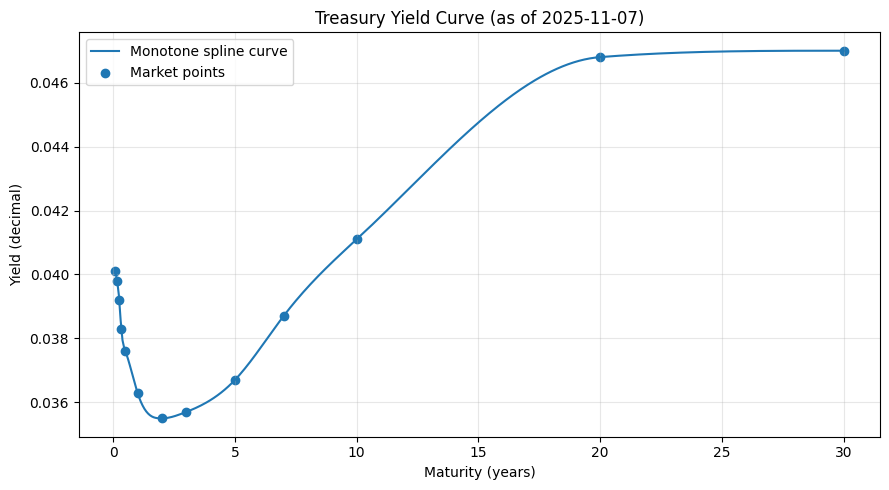

In [60]:
as_of, curve_series = fetch_treasury_yield_curve_latest()

x_points = np.array(curve_series.index, dtype=float)
y_points = np.array(curve_series.values, dtype=float)
x_smooth = np.linspace(x_points.min(), x_points.max(), 400)
y_smooth = interest_rate_interpolation(curve_series, x_smooth)

plt.figure(figsize=(9, 5))
plt.plot(x_smooth, y_smooth, label="Monotone spline curve")
plt.scatter(x_points, y_points, marker="o", label="Market points")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (decimal)")
plt.title(f"Treasury Yield Curve (as of {as_of})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()